# Chapter 07 - Topology optimization

In [1]:
import torch
from math import sqrt
from simple_fem import get_cantilever
import matplotlib.pyplot as plt

# Set plot to use TeX for rendering equations.
plt.rcParams["text.usetex"] = True

torch.set_default_dtype(torch.double)

## Define the cantilever problem

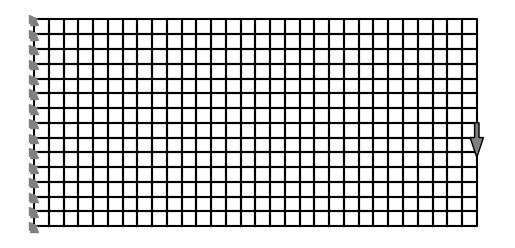

In [2]:
cantilever = get_cantilever(1.0, 30.0, 14.0)
cantilever.plot()

## Optimization with MMA

In [3]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize_mma(fem, rho_0, rho_min, rho_max, V_0, iter=15, s=0.7, p=1.0, r_sens=0.0):
    rho = [rho_0]
    L = []
    areas = fem.areas

    # Precompute filter weights
    if r_sens > 0.0:
        H = r_sens - fem.dist
        H[fem.dist > r_sens] = 0.0

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at rho_k
        u_k, f_k = fem.solve(rho[k])
        
        # Compute sensitivity 
        sensitivity = -p * rho[k] ** (p - 1) * 2.0 * fem.element_strain_energies(u_k)

        # Filter sensitivities (if r_sens provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # Compute lower asymptote
        if k <= 1:
            L_k = rho[k] - s * (rho_max - rho_min)
        else:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (rho[k][j] - rho[k - 1][j]) * (rho[k - 1][j] - rho[k - 2][j]) < 0.0:
                    L_k[j] = rho[k][j] - s * (rho[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = rho[k][j] - 1 / sqrt(s) * (rho[k - 1][j] - L[k - 1][j])
        L.append(L_k)

        # Compute lower move limit in this step
        rho_min_k = torch.maximum(rho_min, 0.9 * L[k] + 0.1 * rho[k])

        # Analytical solution
        def rho_star(mu):
            EPS = 1e-15
            rho_hat = L[k] + torch.sqrt(
                (-sensitivity * (L[k] - rho[k]) ** 2 + EPS) / (mu * areas + EPS)
            )
            return torch.maximum(torch.minimum(rho_hat, rho_max), rho_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(rho_star(mu), areas) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k:3d} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        rho.append(rho_star(mu_star))

    return rho

## Variable thickness optimization (p=1)

Iteration k=  0 - Compliance: 0.42667
Iteration k=  1 - Compliance: 0.74000
Iteration k=  2 - Compliance: 0.61235
Iteration k=  3 - Compliance: 0.60660
Iteration k=  4 - Compliance: 0.60315
Iteration k=  5 - Compliance: 0.60171
Iteration k=  6 - Compliance: 0.60050
Iteration k=  7 - Compliance: 0.59980
Iteration k=  8 - Compliance: 0.59953
Iteration k=  9 - Compliance: 0.59942
Iteration k= 10 - Compliance: 0.59933
Iteration k= 11 - Compliance: 0.59925
Iteration k= 12 - Compliance: 0.59919
Iteration k= 13 - Compliance: 0.59914
Iteration k= 14 - Compliance: 0.59911


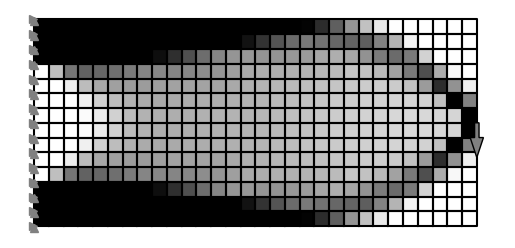

In [4]:
rho_0 = torch.ones(len(cantilever.elements))
rho_min = 0.1 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)
areas = cantilever.areas
V0 = 0.5 * torch.inner(rho_max, areas)

rho_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0)
cantilever.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized.pdf", transparent=True, bbox_inches="tight"
)

## SIMP approach for binarization

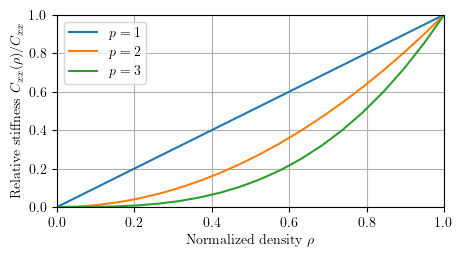

In [5]:
p = 3
Cxx = 1.0

# Plot the SIMP relation
rho = torch.linspace(0, 1, 20)
plt.figure(figsize=(5,2.5))
plt.plot(rho, Cxx * rho**1.0, label="$p=1$")
plt.plot(rho, Cxx * rho**2.0, label="$p=2$")
plt.plot(rho, Cxx * rho**3.0, label="$p=3$")
plt.xlabel(r"$\textrm{Normalized density } \rho$")
plt.ylabel(r"$\textrm{Relative stiffness } C_{xx}(\rho)/C_{xx}$")
plt.xlim([0, 1])
plt.ylim([0, Cxx])
plt.legend()
plt.grid()
plt.savefig("figures/simp.pdf", transparent=True, bbox_inches="tight")

Iteration k=  0 - Compliance: 0.42667
Iteration k=  1 - Compliance: 0.74000
Iteration k=  2 - Compliance: 0.61580
Iteration k=  3 - Compliance: 0.61388
Iteration k=  4 - Compliance: 0.62302
Iteration k=  5 - Compliance: 0.62727
Iteration k=  6 - Compliance: 0.62788
Iteration k=  7 - Compliance: 0.62727
Iteration k=  8 - Compliance: 0.62491
Iteration k=  9 - Compliance: 0.62542
Iteration k= 10 - Compliance: 0.62895
Iteration k= 11 - Compliance: 0.63268
Iteration k= 12 - Compliance: 0.63705
Iteration k= 13 - Compliance: 0.63940
Iteration k= 14 - Compliance: 0.64350
Iteration k= 15 - Compliance: 0.64413
Iteration k= 16 - Compliance: 0.64425
Iteration k= 17 - Compliance: 0.64410
Iteration k= 18 - Compliance: 0.64258
Iteration k= 19 - Compliance: 0.64279
Iteration k= 20 - Compliance: 0.64316
Iteration k= 21 - Compliance: 0.64625
Iteration k= 22 - Compliance: 0.64456
Iteration k= 23 - Compliance: 0.64632
Iteration k= 24 - Compliance: 0.64518


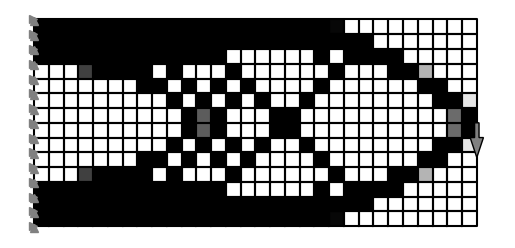

In [6]:
d_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, p=2, iter=25)

cantilever.plot(element_property=d_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary.pdf", transparent=True, bbox_inches="tight"
)

Iteration k=  0 - Compliance: 0.42667
Iteration k=  1 - Compliance: 0.74159
Iteration k=  2 - Compliance: 0.61700
Iteration k=  3 - Compliance: 0.61635
Iteration k=  4 - Compliance: 0.62343
Iteration k=  5 - Compliance: 0.62930
Iteration k=  6 - Compliance: 0.62971
Iteration k=  7 - Compliance: 0.62939
Iteration k=  8 - Compliance: 0.63136
Iteration k=  9 - Compliance: 0.63098
Iteration k= 10 - Compliance: 0.63228
Iteration k= 11 - Compliance: 0.63330
Iteration k= 12 - Compliance: 0.63493
Iteration k= 13 - Compliance: 0.63586
Iteration k= 14 - Compliance: 0.63502
Iteration k= 15 - Compliance: 0.63427
Iteration k= 16 - Compliance: 0.63338
Iteration k= 17 - Compliance: 0.63509
Iteration k= 18 - Compliance: 0.63482
Iteration k= 19 - Compliance: 0.63790
Iteration k= 20 - Compliance: 0.63368
Iteration k= 21 - Compliance: 0.63776
Iteration k= 22 - Compliance: 0.63378
Iteration k= 23 - Compliance: 0.63429
Iteration k= 24 - Compliance: 0.63117
Iteration k= 25 - Compliance: 0.63073
Iteration k=

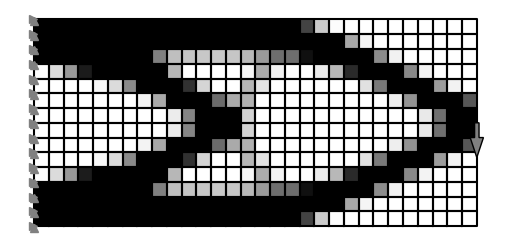

In [7]:
d_opt = optimize_mma(cantilever, rho_0, rho_min, rho_max, V0, p=2, iter=100, r_sens=1.1)
cantilever.plot(element_property=d_opt[-1])

## Optimization with optimality conditions

In [8]:
def optimize_oc(fem, rho_0, rho_min, rho_max, V_0, iter=15, xi=0.5, m=0.2, p=2, r_sens=0.0):
    rho = [rho_0]
    areas = fem.areas

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, areas) > V_0:
        raise Exception("rho_min is not compatible with V_0.")
    
    # Precompute filter weights
    if r_sens > 0.0:
        H = r_sens - fem.dist
        H[fem.dist > r_sens] = 0.0

    # Iterate solutions
    for k in range(iter):
        u_k, f_k = fem.solve(rho[k])
        rho_k = rho[k].clone()

        # Compute sensitivities
        sensitivity = -p * rho[k] ** (p - 1) * 2.0* fem.element_strain_energies(u_k)

        # Filter sensitivities (if r_filt provided)
        if r_sens > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        def make_step(mu):
            # Assuming a certain value of mu, apply the iteration scheme to
            G_k = - sensitivity / (mu * areas)
            upper = torch.min(rho_max, (1 + m) * rho_k)
            lower = torch.max(rho_min, (1 - m) * rho_k)
            rho_trial = G_k**xi * rho_k
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, areas) - V_0

        mu = bisection(g, 0.000001, 1.0, tol=1e-15)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

Iteration k=0 - Compliance: 0.42667
Iteration k=1 - Compliance: 0.53334
Iteration k=2 - Compliance: 0.66667
Iteration k=3 - Compliance: 0.83334
Iteration k=4 - Compliance: 0.74787
Iteration k=5 - Compliance: 0.68451
Iteration k=6 - Compliance: 0.64657
Iteration k=7 - Compliance: 0.63298
Iteration k=8 - Compliance: 0.62980
Iteration k=9 - Compliance: 0.62747
Iteration k=10 - Compliance: 0.62567
Iteration k=11 - Compliance: 0.62524
Iteration k=12 - Compliance: 0.62566
Iteration k=13 - Compliance: 0.62612
Iteration k=14 - Compliance: 0.62640
Iteration k=15 - Compliance: 0.62682
Iteration k=16 - Compliance: 0.62752
Iteration k=17 - Compliance: 0.62829
Iteration k=18 - Compliance: 0.62921
Iteration k=19 - Compliance: 0.62976
Iteration k=20 - Compliance: 0.63021
Iteration k=21 - Compliance: 0.63060
Iteration k=22 - Compliance: 0.63086
Iteration k=23 - Compliance: 0.63118
Iteration k=24 - Compliance: 0.63140
Iteration k=25 - Compliance: 0.63153
Iteration k=26 - Compliance: 0.63170
Iteration k

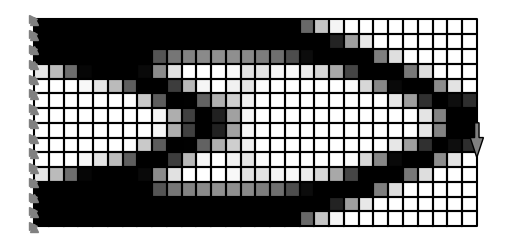

In [9]:
rho_opt = optimize_oc(cantilever, rho_0, rho_min, rho_max, V0, p=2, iter=50, r_sens=1.2)
cantilever.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary_filtered.pdf",
    transparent=True,
    bbox_inches="tight",
)

Iteration k=  0 - Compliance: 0.43228
Iteration k=  1 - Compliance: 0.74350
Iteration k=  2 - Compliance: 0.62130
Iteration k=  3 - Compliance: 0.61990
Iteration k=  4 - Compliance: 0.62717
Iteration k=  5 - Compliance: 0.63240
Iteration k=  6 - Compliance: 0.63300
Iteration k=  7 - Compliance: 0.63315
Iteration k=  8 - Compliance: 0.63352
Iteration k=  9 - Compliance: 0.63308
Iteration k= 10 - Compliance: 0.63368
Iteration k= 11 - Compliance: 0.63452
Iteration k= 12 - Compliance: 0.63622
Iteration k= 13 - Compliance: 0.63744
Iteration k= 14 - Compliance: 0.63778
Iteration k= 15 - Compliance: 0.63921
Iteration k= 16 - Compliance: 0.64074
Iteration k= 17 - Compliance: 0.64135
Iteration k= 18 - Compliance: 0.64155
Iteration k= 19 - Compliance: 0.64179
Iteration k= 20 - Compliance: 0.64166
Iteration k= 21 - Compliance: 0.64195
Iteration k= 22 - Compliance: 0.64155
Iteration k= 23 - Compliance: 0.64196
Iteration k= 24 - Compliance: 0.64197
Iteration k= 25 - Compliance: 0.64231
Iteration k=

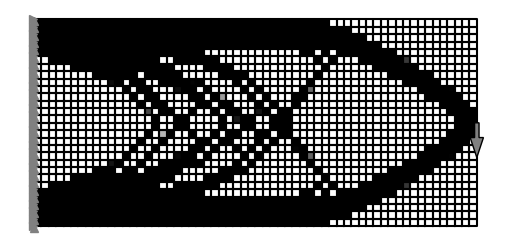

In [10]:
cantilever_fine = get_cantilever(0.5, 30.0, 14.0)

rho_0 = torch.ones(len(cantilever_fine.elements))
rho_min = 0.1 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)
areas = cantilever_fine.areas
V0 = 0.5 * torch.inner(rho_max, areas)


rho_opt = optimize_mma(cantilever_fine, rho_0, rho_min, rho_max, V0, p=2, iter=50)
cantilever_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary_fine.pdf", transparent=True, bbox_inches="tight"
)

Iteration k=0 - Compliance: 0.43228
Iteration k=1 - Compliance: 0.54035
Iteration k=2 - Compliance: 0.67543
Iteration k=3 - Compliance: 0.84429
Iteration k=4 - Compliance: 0.75651
Iteration k=5 - Compliance: 0.69111
Iteration k=6 - Compliance: 0.65111
Iteration k=7 - Compliance: 0.63488
Iteration k=8 - Compliance: 0.62959
Iteration k=9 - Compliance: 0.62638
Iteration k=10 - Compliance: 0.62456
Iteration k=11 - Compliance: 0.62445
Iteration k=12 - Compliance: 0.62571
Iteration k=13 - Compliance: 0.62824
Iteration k=14 - Compliance: 0.63167
Iteration k=15 - Compliance: 0.63356
Iteration k=16 - Compliance: 0.63418
Iteration k=17 - Compliance: 0.63516
Iteration k=18 - Compliance: 0.63647
Iteration k=19 - Compliance: 0.63782
Iteration k=20 - Compliance: 0.63900
Iteration k=21 - Compliance: 0.63959
Iteration k=22 - Compliance: 0.63981
Iteration k=23 - Compliance: 0.63984
Iteration k=24 - Compliance: 0.63987
Iteration k=25 - Compliance: 0.64004
Iteration k=26 - Compliance: 0.64019
Iteration k

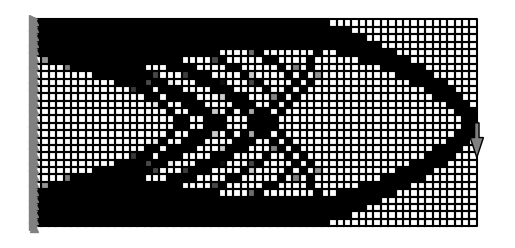

In [11]:
rho_opt = optimize_oc(cantilever_fine, rho_0, rho_min, rho_max, V0, p=2, iter=50)
cantilever_fine.plot(element_property=rho_opt[-1])

Iteration k=0 - Compliance: 0.43228
Iteration k=1 - Compliance: 0.54035
Iteration k=2 - Compliance: 0.67543
Iteration k=3 - Compliance: 0.84429
Iteration k=4 - Compliance: 0.75679
Iteration k=5 - Compliance: 0.69184
Iteration k=6 - Compliance: 0.65241
Iteration k=7 - Compliance: 0.63711
Iteration k=8 - Compliance: 0.63359
Iteration k=9 - Compliance: 0.63132
Iteration k=10 - Compliance: 0.62977
Iteration k=11 - Compliance: 0.62964
Iteration k=12 - Compliance: 0.63046
Iteration k=13 - Compliance: 0.63100
Iteration k=14 - Compliance: 0.63164
Iteration k=15 - Compliance: 0.63254
Iteration k=16 - Compliance: 0.63364
Iteration k=17 - Compliance: 0.63473
Iteration k=18 - Compliance: 0.63552
Iteration k=19 - Compliance: 0.63604
Iteration k=20 - Compliance: 0.63645
Iteration k=21 - Compliance: 0.63678
Iteration k=22 - Compliance: 0.63702
Iteration k=23 - Compliance: 0.63727
Iteration k=24 - Compliance: 0.63752
Iteration k=25 - Compliance: 0.63781
Iteration k=26 - Compliance: 0.63811
Iteration k

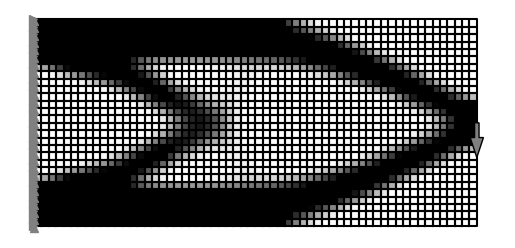

In [12]:
rho_opt = optimize_oc(cantilever_fine, rho_0, rho_min, rho_max, V0, p=2, iter=50, r_sens=1.1)
cantilever_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary_fine_filtered.pdf", transparent=True, bbox_inches="tight"
)

Iteration k=  0 - Compliance: 0.36661
Iteration k=  1 - Compliance: 0.63069
Iteration k=  2 - Compliance: 0.53087
Iteration k=  3 - Compliance: 0.52934
Iteration k=  4 - Compliance: 0.53621
Iteration k=  5 - Compliance: 0.54128
Iteration k=  6 - Compliance: 0.54184
Iteration k=  7 - Compliance: 0.54123
Iteration k=  8 - Compliance: 0.54187
Iteration k=  9 - Compliance: 0.54196
Iteration k= 10 - Compliance: 0.54285
Iteration k= 11 - Compliance: 0.54346
Iteration k= 12 - Compliance: 0.54434
Iteration k= 13 - Compliance: 0.54555
Iteration k= 14 - Compliance: 0.54599
Iteration k= 15 - Compliance: 0.54628
Iteration k= 16 - Compliance: 0.54657
Iteration k= 17 - Compliance: 0.54699
Iteration k= 18 - Compliance: 0.54705
Iteration k= 19 - Compliance: 0.54709


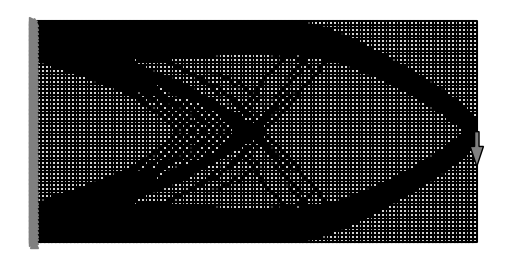

In [13]:
cantilever_extra_fine = get_cantilever(0.25, 30.0, 15.0)

rho_0 = torch.ones(len(cantilever_extra_fine.elements))
rho_min = 0.1 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)
areas = cantilever_extra_fine.areas
V0 = 0.5 * torch.inner(rho_max, areas)


rho_opt = optimize_mma(cantilever_extra_fine, rho_0, rho_min, rho_max, V0, p=2, iter=20)
cantilever_extra_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary_extra_fine.pdf", transparent=True, bbox_inches="tight"
)

Iteration k=0 - Compliance: 0.36661
Iteration k=1 - Compliance: 0.45826
Iteration k=2 - Compliance: 0.57283
Iteration k=3 - Compliance: 0.71604
Iteration k=4 - Compliance: 0.64410
Iteration k=5 - Compliance: 0.59074
Iteration k=6 - Compliance: 0.55802
Iteration k=7 - Compliance: 0.54460
Iteration k=8 - Compliance: 0.54120
Iteration k=9 - Compliance: 0.53885
Iteration k=10 - Compliance: 0.53727
Iteration k=11 - Compliance: 0.53721
Iteration k=12 - Compliance: 0.53820
Iteration k=13 - Compliance: 0.53905
Iteration k=14 - Compliance: 0.53996
Iteration k=15 - Compliance: 0.54104
Iteration k=16 - Compliance: 0.54206
Iteration k=17 - Compliance: 0.54279
Iteration k=18 - Compliance: 0.54332
Iteration k=19 - Compliance: 0.54372
Iteration k=20 - Compliance: 0.54404
Iteration k=21 - Compliance: 0.54430
Iteration k=22 - Compliance: 0.54454
Iteration k=23 - Compliance: 0.54479
Iteration k=24 - Compliance: 0.54507
Iteration k=25 - Compliance: 0.54538
Iteration k=26 - Compliance: 0.54571
Iteration k

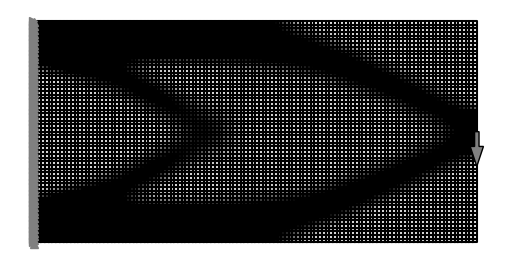

In [14]:
rho_opt = optimize_oc(cantilever_extra_fine, rho_0, rho_min, rho_max, V0, p=2, iter=50, r_sens=1.1)
cantilever_extra_fine.plot(element_property=rho_opt[-1])
plt.savefig(
    "figures/cantilever_fem_optimized_binary_extra_fine_filtered.pdf", transparent=True, bbox_inches="tight"
)